In [1]:
# Objectives:
# 1. Set up a basic example using TensorFlow Ranking using our dataset.
# 2. Run it successfully end to end even if the results are not good.
# 3. Clean up the data loading part

In [2]:
EPOCHS = 10
BATCH_SIZE = 16

In [3]:
import numpy as np
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
import pandas as pd

In [5]:
import tensorflow as tf
print(tf.__version__)


2.15.1


In [6]:
from tensorflow.keras import layers
print(layers)
# Our dataset is definitely heterogenous therefore we need to follow this guide and build the preprocessing into the model
# https://www.tensorflow.org/tutorials/load_data/pandas_dataframe#full_example

<module 'keras.api._v2.keras.layers' from 'C:\\Users\\chris\\AppData\\Local\\anaconda3\\envs\\rankenv\\lib\\site-packages\\keras\\api\\_v2\\keras\\layers\\__init__.py'>


In [7]:
# from typing import Dict, Tuple
# import tensorflow_datasets as tfds

In [8]:

# Import our custom Dataloader
from data_loader import DataLoader

# Create an instance of DataLoader and pass the name of the dir that holds the dataset
data_loader = DataLoader(data_dir="data")


In [9]:

# Read cell line to drug id to ic50
# https://depmap.org/portal/data_page/?tab=allData&releasename=Sanger+GDSC1+and+GDSC2&filename=sanger-dose-response.csv
# IC50 score of drugs (DRUG_ID) per cell line (COSMIC_ID) for GDSC1 and GDSC2 

# Load the "resopnse" data
df_response = data_loader.load_data('sanger-dose-response.csv')

df_response = df_response.query('DATASET == "GDSC2"')
df_response = df_response.filter(items=["DRUG_ID", "ARXSPAN_ID", "IC50_PUBLISHED"])
print(df_response)

sanger-dose-response.csv read successfully.
        DRUG_ID  ARXSPAN_ID  IC50_PUBLISHED
268718     1003  ACH-000958        0.025129
268719     1003  ACH-000651        0.049577
268720     1003  ACH-000856        0.028549
268721     1003  ACH-000360        0.039996
268722     1003  ACH-001199        1.986678
...         ...         ...             ...
387621     2172  ACH-000288       25.410793
387622     2172  ACH-001065        0.339325
387623     2172  ACH-000930        7.780877
387624     2172  ACH-000859      534.688321
387625     2172  ACH-000536      120.177282

[118908 rows x 3 columns]


In [10]:

# Read the Model.csv
# This dataset contains demographics and cancer type
# https://depmap.org/portal/data_page/?tab=allData&releasename=DepMap+Public+24Q2&filename=Model.csv
# Mapping between 'ModelID', 'PatientID', 'SangerModelID', 'COSMICID', etc
# ModelID here is the cell line id.
# OncotreeCode is the type of cancer.

df_model = data_loader.load_data('Model.csv')
df_model = df_model.filter(items=['ModelID', 
                                  'OncotreeCode', 
                                  'AgeCategory', 
                                  'Sex'])
                                  # 'PatientRace', 
                                  # 'PrimaryOrMetastasis'])
print(df_model)

# Check for any remaining missing values
print(df_model.isnull().sum())
# [1959 rows x 4 columns]
# ModelID           0
# OncotreeCode    141
# AgeCategory       0
# Sex              25
# dtype: int64
df_model['OncotreeCode'] = df_model['OncotreeCode'].fillna('Unknown')
df_model['OncotreeCode'] = df_model['OncotreeCode'].fillna('NON_CANCEROUS')


Model.csv read successfully.
         ModelID OncotreeCode AgeCategory     Sex
0     ACH-000001        HGSOC       Adult  Female
1     ACH-000002          AML       Adult  Female
2     ACH-000003         COAD       Adult    Male
3     ACH-000004          AML       Adult    Male
4     ACH-000005          AML       Adult    Male
...          ...          ...         ...     ...
1954  ACH-003161          NaN     Unknown     NaN
1955  ACH-003181          LMS       Adult  Female
1956  ACH-003183          MFS       Adult    Male
1957  ACH-003184          LMS       Adult  Female
1958  ACH-003191         GCTB       Adult    Male

[1959 rows x 4 columns]
ModelID           0
OncotreeCode    141
AgeCategory       0
Sex              25
dtype: int64


In [11]:

# Load the gene expression data from "OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected"
df_expression = data_loader.load_data("OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected.csv")

# The first column header which is the cell line id happens to be empty in the dataset, so we set it manually
df_expression = df_expression.rename(columns={'': 'ARXSPAN_ID'})

# Select specific columns
df_expression = df_expression[['ARXSPAN_ID',
                               'ZMIZ1 (57178)', 
                               'ENG (2022)',
                               'FGFR1 (2260)',
                               'PAWR (5074)']] 
                               # 'KRT17 (3872)', 
                               # 'MPO (4353)',
                               # 'LAT2 (7462)']]
print(df_expression)

OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected.csv read successfully.
      ARXSPAN_ID  ZMIZ1 (57178)  ENG (2022)  FGFR1 (2260)  PAWR (5074)
0     ACH-000058       5.625773    4.795912      4.550313     5.691600
1     ACH-000082       5.744045    6.685257      7.885196     1.309678
2     ACH-000867       4.740270    3.052492      2.024326     4.669322
3     ACH-000437       6.113573    6.810016      6.047486     4.245211
4     ACH-000544       3.368808    0.071018      0.312412     3.782876
...          ...            ...         ...           ...          ...
1512  ACH-001743       4.140309    1.357624      5.281085     4.031491
1513  ACH-001578       5.544128    0.617270      8.321176     4.445862
1514  ACH-002669       2.527378    0.700254      0.629052     4.718483
1515  ACH-001858       5.641719    6.415130      5.081939     5.225997
1516  ACH-001997       4.608237    3.047769      0.302899     5.484335

[1517 rows x 5 columns]


In [12]:

# Join response and model

try:
    assert df_response["ARXSPAN_ID"].dtype == df_model["ModelID"].dtype
    df_response_model = pd.merge(df_response, df_model, left_on='ARXSPAN_ID', right_on='ModelID')
    df_response_model = df_response_model.drop('ModelID', axis=1) # we drop ModelID since it's the same info as ARXSPAN_ID 
    print("Shape of df_response_model = {}".format(df_response_model.shape))
    print(df_response_model.head())
except Exception as e:
    print(f"Error: {e}")
    

Shape of df_response_model = (115502, 6)
   DRUG_ID  ARXSPAN_ID  IC50_PUBLISHED OncotreeCode AgeCategory     Sex
0     1003  ACH-000958        0.025129         COAD       Adult  Female
1     1003  ACH-000651        0.049577         COAD       Adult    Male
2     1003  ACH-000856        0.028549         BRCA       Adult  Female
3     1003  ACH-000360        0.039996         COAD       Adult    Male
4     1003  ACH-001199        1.986678         COAD       Adult  Female


In [13]:

# Join response_model and expression

try:
    assert df_response_model['ARXSPAN_ID'].dtype == df_expression['ARXSPAN_ID'].dtype
    df_response_model_expression = pd.merge(df_response_model, df_expression, left_on='ARXSPAN_ID', right_on='ARXSPAN_ID')
    print("Shape of df_response_model_expression = {}".format(df_response_model_expression.shape))
    print(df_response_model_expression.head())
except Exception as e:
    print(f"Error: {e}")


Shape of df_response_model_expression = (88976, 10)
   DRUG_ID  ARXSPAN_ID  IC50_PUBLISHED OncotreeCode AgeCategory     Sex  \
0     1003  ACH-000958        0.025129         COAD       Adult  Female   
1     1003  ACH-000651        0.049577         COAD       Adult    Male   
2     1003  ACH-000856        0.028549         BRCA       Adult  Female   
3     1003  ACH-000360        0.039996         COAD       Adult    Male   
4     1003  ACH-000400        0.004820         COAD       Adult    Male   

   ZMIZ1 (57178)  ENG (2022)  FGFR1 (2260)  PAWR (5074)  
0       2.882901    3.896383      1.022058     4.631481  
1       3.227695    1.078813      5.141713     4.124477  
2       3.945238    0.059106      5.912215     4.875870  
3       3.358643    2.312424      0.553884     3.706209  
4       3.129009    3.147827      0.109936     5.092328  


In [14]:

# Persist csv right after join and before split for classification
df_response_model_expression.to_csv('data/df_response_model_expression.csv', index=False)


In [15]:
df_response_model_expression.dtypes

DRUG_ID             int64
ARXSPAN_ID         object
IC50_PUBLISHED    float64
OncotreeCode       object
AgeCategory        object
Sex                object
ZMIZ1 (57178)     float64
ENG (2022)        float64
FGFR1 (2260)      float64
PAWR (5074)       float64
dtype: object

In [16]:
features = df_response_model_expression
target = features.pop('IC50_PUBLISHED')

In [17]:
# Necessary setup to convert the problem to classification just for testing.
bins = [0, 1, 10, 100, float('inf')]
labels = ['HIGH', 'MODERATE', 'LOW', 'INACTIVE']
target_binned = pd.cut(target, bins=bins, labels=labels, right=False)
num_classes = len(np.unique(target_binned))
print(num_classes)


# Convert CategoricalDtype to string
target_binned = target_binned.astype(str)

# Convert the categorical labels to numeric indices using StringLookup
lookup = tf.keras.layers.StringLookup(vocabulary=labels, mask_token=None, num_oov_indices=0, output_mode='int')
target_indices = lookup(target_binned)

# Ensure that the indices are in the range [0, len(labels)-1]
num_classes = len(labels)  # Should be 4 in this case

# Now use CategoryEncoding to one-hot encode these indices
target_one_hot = tf.keras.layers.CategoryEncoding(num_tokens=num_classes, output_mode='one_hot')(target_indices)


4




In [18]:
# https://www.tensorflow.org/tutorials/load_data/pandas_dataframe#build_the_preprocessing_head

In [19]:
# Build the preprocessing head
binary_feature_names = []
categorical_feature_names = ['DRUG_ID', 'ARXSPAN_ID', 'OncotreeCode', 'AgeCategory', 'Sex']

inputs = {}
for name, column in features.items():
  if type(column[0]) == str:
    dtype = tf.string
  elif (name in categorical_feature_names or
        name in binary_feature_names):
    dtype = tf.int64
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'DRUG_ID': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'DRUG_ID')>,
 'ARXSPAN_ID': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'ARXSPAN_ID')>,
 'OncotreeCode': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'OncotreeCode')>,
 'AgeCategory': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'AgeCategory')>,
 'Sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Sex')>,
 'ZMIZ1 (57178)': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ZMIZ1 (57178)')>,
 'ENG (2022)': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ENG (2022)')>,
 'FGFR1 (2260)': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'FGFR1 (2260)')>,
 'PAWR (5074)': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'PAWR (5074)')>}

In [20]:
preprocessed = []

In [21]:
# # Binary inputs

# for name in binary_feature_names:
#   inp = inputs[name]
#   preprocessed.append(inp)

# preprocessed

In [22]:
# Numeric inputs
numeric_feature_names = ['ZMIZ1 (57178)', 'ENG (2022)']
numeric_features = features[numeric_feature_names]

numeric_features_dict = {key: value.to_numpy()[:, tf.newaxis] for key, value in dict(numeric_features).items()}

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.concatenate([value for key, value in sorted(numeric_features_dict.items())], axis=1))

numeric_inputs = []
for name in numeric_feature_names:
  numeric_inputs.append(inputs[name])

numeric_inputs = tf.keras.layers.Concatenate(axis=-1)(numeric_inputs)
numeric_normalized = normalizer(numeric_inputs)

preprocessed.append(numeric_normalized)

preprocessed

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'normalization')>]

In [23]:
# Categorical features
for name in categorical_feature_names:
    print(name)
    vocab = sorted(set(features[name]))
    print(f'name: {name}')
    print(f'vocab: {vocab}\n')
    
    if type(vocab[0]) is str:
        lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
    else:
        lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')
    x = inputs[name]
    x = lookup(x)
    preprocessed.append(x)


DRUG_ID
name: DRUG_ID
vocab: [1003, 1004, 1005, 1006, 1007, 1010, 1011, 1012, 1013, 1017, 1021, 1022, 1025, 1030, 1032, 1036, 1038, 1042, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1057, 1058, 1059, 1060, 1068, 1073, 1079, 1080, 1083, 1084, 1085, 1086, 1088, 1089, 1091, 1093, 1096, 1129, 1131, 1168, 1177, 1179, 1180, 1190, 1191, 1192, 1194, 1199, 1200, 1237, 1239, 1248, 1249, 1250, 1259, 1268, 1372, 1373, 1375, 1507, 1510, 1511, 1512, 1529, 1549, 1553, 1557, 1558, 1559, 1560, 1561, 1563, 1564, 1576, 1578, 1593, 1594, 1598, 1613, 1614, 1615, 1617, 1618, 1620, 1621, 1622, 1624, 1625, 1626, 1627, 1629, 1630, 1631, 1632, 1634, 1635, 1786, 1799, 1802, 1804, 1806, 1807, 1808, 1809, 1810, 1811, 1813, 1814, 1816, 1818, 1819, 1825, 1827, 1830, 1835, 1838, 1849, 1852, 1853, 1854, 1855, 1866, 1873, 1908, 1909, 1910, 1911, 1912, 1913, 1915, 1916, 1917, 1918, 1919, 1922, 1924, 1925, 1926, 1927, 1928, 1930, 1931, 1932, 1933, 1936, 1939, 1940, 1941, 1996, 1997, 1998, 2040, 2043, 2044, 2045

In [24]:
preprocessed_result = tf.keras.layers.Concatenate(axis=1)(preprocessed)
preprocessed_result

<KerasTensor: shape=(None, 896) dtype=float32 (created by layer 'concatenate_1')>

In [25]:
preprocessor = tf.keras.Model(inputs, preprocessed_result)

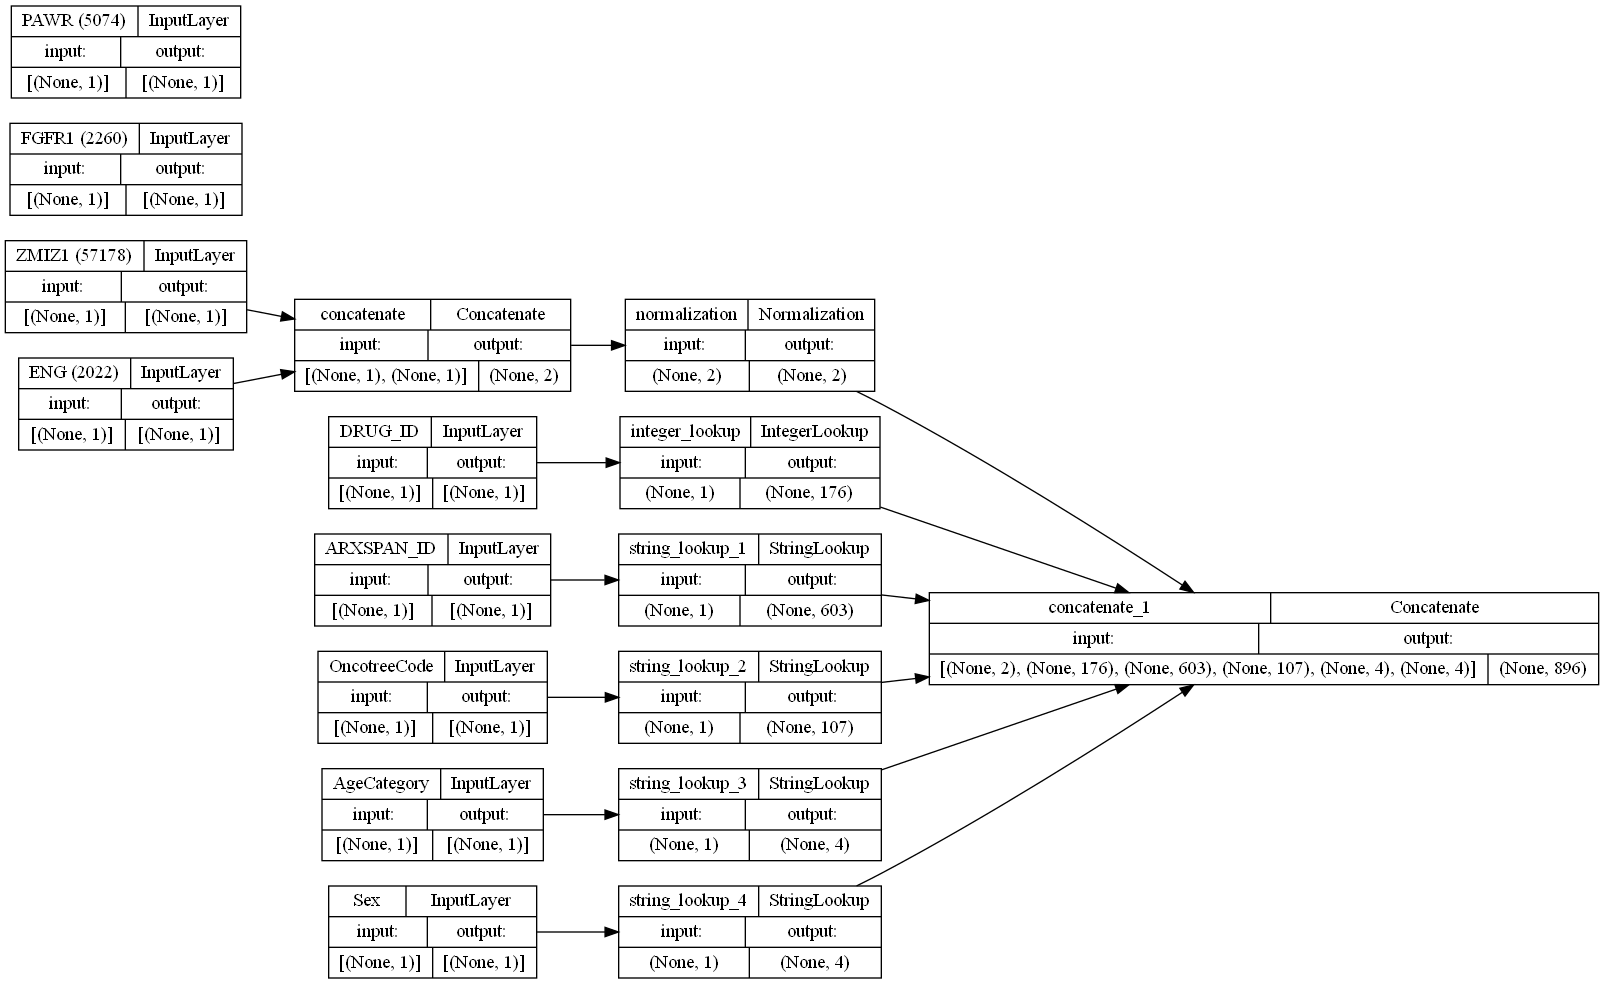

In [26]:
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True,  show_layer_names=True)

In [27]:
# preprocessor(dict(df_response_model_expression.iloc[:1]))

In [28]:
body = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [29]:
inputs

{'DRUG_ID': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'DRUG_ID')>,
 'ARXSPAN_ID': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'ARXSPAN_ID')>,
 'OncotreeCode': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'OncotreeCode')>,
 'AgeCategory': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'AgeCategory')>,
 'Sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Sex')>,
 'ZMIZ1 (57178)': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ZMIZ1 (57178)')>,
 'ENG (2022)': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ENG (2022)')>,
 'FGFR1 (2260)': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'FGFR1 (2260)')>,
 'PAWR (5074)': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'PAWR (5074)')>}

In [30]:
x = preprocessor(inputs)
x

<KerasTensor: shape=(None, 896) dtype=float32 (created by layer 'model')>

In [31]:
result = body(x)
result

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'sequential')>

In [32]:
model = tf.keras.Model(inputs, result)

model.compile(optimizer='adam',
                # loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'
                    # tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
                    # tf.keras.metrics.Precision(name='precision'),
                    # tf.keras.metrics.Recall(name='recall'),
                    # tf.keras.metrics.AUC(name='auc'),
                    # tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy')
                ])

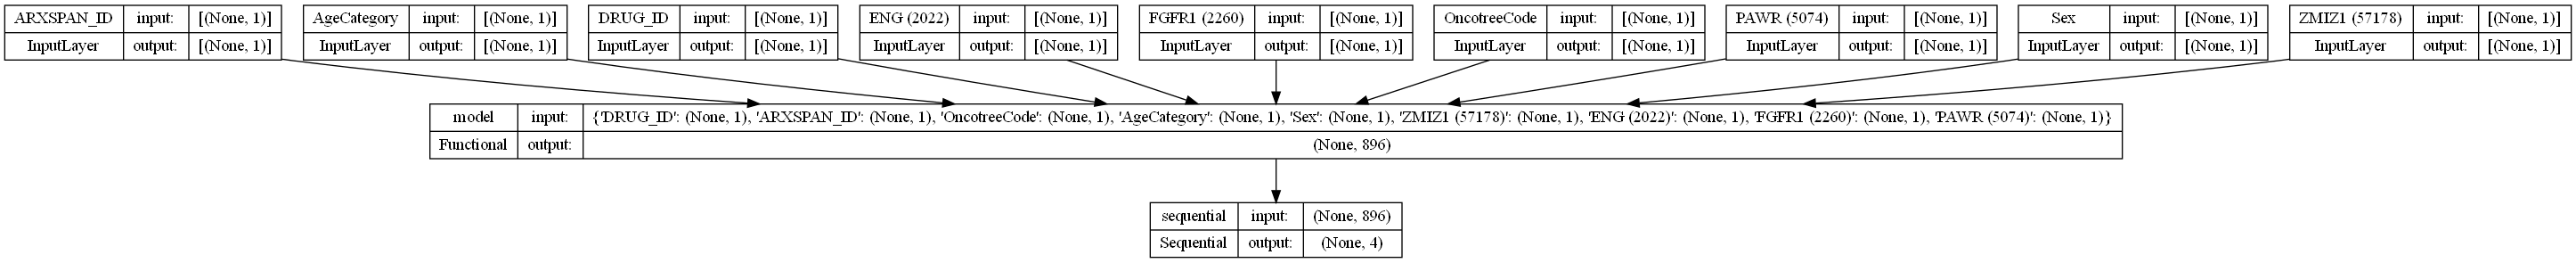

In [33]:
tf.keras.utils.plot_model(model, show_shapes=True,  show_layer_names=True)

In [34]:
history = model.fit(dict(df_response_model_expression), target_one_hot, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10

5561/5561 [==============================] - 47s 8ms/step - loss: 0.7696 - accuracy: 0.6554
Epoch 2/10
5561/5561 [==============================] - 43s 8ms/step - loss: 0.6715 - accuracy: 0.7009
Epoch 3/10
5561/5561 [==============================] - 45s 8ms/step - loss: 0.6366 - accuracy: 0.7170
Epoch 4/10
5561/5561 [==============================] - 43s 8ms/step - loss: 0.6072 - accuracy: 0.7304
Epoch 5/10
5561/5561 [==============================] - 43s 8ms/step - loss: 0.5801 - accuracy: 0.7445
Epoch 6/10
5561/5561 [==============================] - 44s 8ms/step - loss: 0.5565 - accuracy: 0.7557
Epoch 7/10
5561/5561 [==============================] - 44s 8ms/step - loss: 0.5379 - accuracy: 0.7665
Epoch 8/10
5561/5561 [==============================] - 41s 7ms/step - loss: 0.5192 - accuracy: 0.7745
Epoch 9/10
5561/5561 [==============================] - 43s 8ms/step - loss: 0.5050 - accuracy: 0.7802
Epoch 10/10
5561/5561 [==============================] - 44s 8ms/step - 